In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.dummy import DummyRegressor
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from time import time
from xgboost import XGBRegressor

pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', None)

## Order Products

The first thing we're going to do is consolidate items per order. Currently we have multiple rows per order. When we're done we're going to have one row per order.

In [2]:
order_products = pd.read_csv('./data/order_products.csv')

In [3]:
order_products.shape

(198500, 4)

In [4]:
order_products.head()

,order_id,product_id,quantity,buy_unit
0,47099653730fb1b76537fc10ad876255,c1244453d731c77416cb4766e3bd76cb,1.0,UN
1,689d8866915acf87e851c2591a23a82f,43cc2b100bec640fe563cd16f2db669f,1.0,KG
2,f26d16bf6f38c9e31d0be877f4013a9e,b8f880759d014134e272d881d49989a2,1.0,UN
3,161ccc896835ab41761b0e726becb6b1,dbc062b9bef805d27a6f4bea7edfe1f1,1.0,UN
4,4713deca10bb5db98fae150b52d61fc0,93a060f269bb569398921100f84c519a,2.0,UN


In [5]:
order_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198500 entries, 0 to 198499
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   order_id    198500 non-null  object 
 1   product_id  198500 non-null  object 
 2   quantity    198500 non-null  float64
 3   buy_unit    198500 non-null  object 
dtypes: float64(1), object(3)
memory usage: 6.1+ MB


In order to group items per order, we have to sum up all the quantities by `order_id` and `buy_unit` of the product. We're going to end up with two rows per order, because we have two types of unit (*UN* and *KG*). We can then pivot the dataframe using the types of unit as columns to get one row per order.

In [6]:
total_quantity = order_products.groupby(['order_id', 'buy_unit']).sum().reset_index()
total_quantity.head()

,order_id,buy_unit,quantity
0,0004a3841c1eeb6c6e77585a941c21e0,UN,8.000
1,0005a6ecbbde1e8d273f5577bcff2c9c,UN,2.000
2,0007baeb6700fc203be2d1f1e11222d7,UN,39.000
3,0012195a6a8ca9ec308a3010eeea8ebc,UN,13.000
4,0013011fa72b498b9feb84f4e7104980,KG,1.636


In [7]:
total_quantity = total_quantity.pivot(index='order_id', columns='buy_unit', values='quantity').reset_index()
total_quantity.head()

buy_unit,order_id,KG,UN
0,0004a3841c1eeb6c6e77585a941c21e0,NaN,8.0
1,0005a6ecbbde1e8d273f5577bcff2c9c,NaN,2.0
2,0007baeb6700fc203be2d1f1e11222d7,NaN,39.0
3,0012195a6a8ca9ec308a3010eeea8ebc,NaN,13.0
4,0013011fa72b498b9feb84f4e7104980,1.636,63.0


Some of the columns contain NaNs and we can fill them with 0s for now.

In [8]:
total_quantity.fillna(0, inplace=True)
total_quantity.head()

buy_unit,order_id,KG,UN
0,0004a3841c1eeb6c6e77585a941c21e0,0.000,8.0
1,0005a6ecbbde1e8d273f5577bcff2c9c,0.000,2.0
2,0007baeb6700fc203be2d1f1e11222d7,0.000,39.0
3,0012195a6a8ca9ec308a3010eeea8ebc,0.000,13.0
4,0013011fa72b498b9feb84f4e7104980,1.636,63.0


We can then count how many unique products each order has and merge the two dataframes we created.

In [9]:
num_products = order_products.groupby(['order_id'])['product_id'].count().reset_index()
num_products.head()

,order_id,product_id
0,0004a3841c1eeb6c6e77585a941c21e0,4
1,0005a6ecbbde1e8d273f5577bcff2c9c,1
2,0007baeb6700fc203be2d1f1e11222d7,22
3,0012195a6a8ca9ec308a3010eeea8ebc,11
4,0013011fa72b498b9feb84f4e7104980,44


In [10]:
total_order_products = pd.merge(num_products, total_quantity, on=['order_id'])
total_order_products.head()

,order_id,product_id,KG,UN
0,0004a3841c1eeb6c6e77585a941c21e0,4,0.000,8.0
1,0005a6ecbbde1e8d273f5577bcff2c9c,1,0.000,2.0
2,0007baeb6700fc203be2d1f1e11222d7,22,0.000,39.0
3,0012195a6a8ca9ec308a3010eeea8ebc,11,0.000,13.0
4,0013011fa72b498b9feb84f4e7104980,44,1.636,63.0


Let's rename the column `product_id` to a more fitting name and convert the columns `KG` and `UN` names to lower case just to be consistent with the naming style.

In [11]:
total_order_products.rename(columns={'product_id': 'num_products', 'KG': 'kg', 'UN': 'un'}, inplace=True)
total_order_products.head()

,order_id,num_products,kg,un
0,0004a3841c1eeb6c6e77585a941c21e0,4,0.000,8.0
1,0005a6ecbbde1e8d273f5577bcff2c9c,1,0.000,2.0
2,0007baeb6700fc203be2d1f1e11222d7,22,0.000,39.0
3,0012195a6a8ca9ec308a3010eeea8ebc,11,0.000,13.0
4,0013011fa72b498b9feb84f4e7104980,44,1.636,63.0


In [12]:
total_order_products.shape

(9978, 4)

## Orders

In [13]:
orders = pd.read_csv('./data/orders.csv')

In [14]:
orders.shape

(10000, 8)

In [15]:
orders.head()

,order_id,lat,lng,promised_time,on_demand,shopper_id,store_branch_id,total_minutes
0,e750294655c2c7c34d83cc3181c09de4,-33.501675,-70.579369,2019-10-18 20:48:00+00:00,True,e63bc83a1a952fa2b3cc9d558fb943cf,65ded5353c5ee48d0b7d48c591b8f430,67.684264
1,6581174846221cb6c467348e87f57641,-33.440584,-70.556283,2019-10-19 01:00:00+00:00,False,195f9e9d84a4ba9033c4b6a756334d8b,45fbc6d3e05ebd93369ce542e8f2322d,57.060632
2,3a226ea48debc0a7ae9950d5540f2f34,-32.987022,-71.544842,2019-10-19 14:54:00+00:00,True,a5b9ddc0d82e61582fca19ad43dbaacb,07563a3fe3bbe7e3ba84431ad9d055af,NaN
3,7d2ed03fe4966083e74b12694b1669d8,-33.328075,-70.512659,2019-10-18 21:47:00+00:00,True,d0b3f6bf7e249e5ebb8d3129341773a2,f1748d6b0fd9d439f71450117eba2725,52.067742
4,b4b2682d77118155fe4716300ccf7f39,-33.403239,-70.564020,2019-10-19 20:00:00+00:00,False,5c5199ce02f7b77caa9c2590a39ad27d,1f0e3dad99908345f7439f8ffabdffc4,140.724822


In [16]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   order_id         10000 non-null  object 
 1   lat              10000 non-null  float64
 2   lng              10000 non-null  float64
 3   promised_time    10000 non-null  object 
 4   on_demand        10000 non-null  bool   
 5   shopper_id       10000 non-null  object 
 6   store_branch_id  10000 non-null  object 
 7   total_minutes    8000 non-null   float64
dtypes: bool(1), float64(3), object(4)
memory usage: 556.8+ KB


The `promised_time` feature is probably going to be useful, but we have to preprocess it, in order for our model to be able to use it. First, we have to make sure we have a datetime object, and then we can extract other features from it, such as day of the week, week of the year, and so on. After that, we can drop the `promised_time` column.

In [17]:
orders['promised_time'] = pd.to_datetime(orders['promised_time'])

In [18]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

orders['promised_weekday'] = orders['promised_time'].dt.weekday
orders['promised_weekofyear'] = orders['promised_time'].dt.weekofyear
orders['promised_hour'] = orders['promised_time'].dt.hour
orders['promised_minute'] = orders['promised_time'].dt.minute
orders['promised_weekhour'] = orders['promised_weekday'] * 24 + orders['promised_hour']

In [19]:
orders = orders.drop('promised_time', axis=1)

In [20]:
orders.head()

,order_id,lat,lng,on_demand,shopper_id,store_branch_id,total_minutes,promised_weekday,promised_weekofyear,promised_hour,promised_minute,promised_weekhour
0,e750294655c2c7c34d83cc3181c09de4,-33.501675,-70.579369,True,e63bc83a1a952fa2b3cc9d558fb943cf,65ded5353c5ee48d0b7d48c591b8f430,67.684264,4,42,20,48,116
1,6581174846221cb6c467348e87f57641,-33.440584,-70.556283,False,195f9e9d84a4ba9033c4b6a756334d8b,45fbc6d3e05ebd93369ce542e8f2322d,57.060632,5,42,1,0,121
2,3a226ea48debc0a7ae9950d5540f2f34,-32.987022,-71.544842,True,a5b9ddc0d82e61582fca19ad43dbaacb,07563a3fe3bbe7e3ba84431ad9d055af,NaN,5,42,14,54,134
3,7d2ed03fe4966083e74b12694b1669d8,-33.328075,-70.512659,True,d0b3f6bf7e249e5ebb8d3129341773a2,f1748d6b0fd9d439f71450117eba2725,52.067742,4,42,21,47,117
4,b4b2682d77118155fe4716300ccf7f39,-33.403239,-70.564020,False,5c5199ce02f7b77caa9c2590a39ad27d,1f0e3dad99908345f7439f8ffabdffc4,140.724822,5,42,20,0,140


We also have to convert `on_demand` from boolean to numeric.

In [21]:
orders['on_demand'] = orders['on_demand'].astype(int)
orders.head()

,order_id,lat,lng,on_demand,shopper_id,store_branch_id,total_minutes,promised_weekday,promised_weekofyear,promised_hour,promised_minute,promised_weekhour
0,e750294655c2c7c34d83cc3181c09de4,-33.501675,-70.579369,1,e63bc83a1a952fa2b3cc9d558fb943cf,65ded5353c5ee48d0b7d48c591b8f430,67.684264,4,42,20,48,116
1,6581174846221cb6c467348e87f57641,-33.440584,-70.556283,0,195f9e9d84a4ba9033c4b6a756334d8b,45fbc6d3e05ebd93369ce542e8f2322d,57.060632,5,42,1,0,121
2,3a226ea48debc0a7ae9950d5540f2f34,-32.987022,-71.544842,1,a5b9ddc0d82e61582fca19ad43dbaacb,07563a3fe3bbe7e3ba84431ad9d055af,NaN,5,42,14,54,134
3,7d2ed03fe4966083e74b12694b1669d8,-33.328075,-70.512659,1,d0b3f6bf7e249e5ebb8d3129341773a2,f1748d6b0fd9d439f71450117eba2725,52.067742,4,42,21,47,117
4,b4b2682d77118155fe4716300ccf7f39,-33.403239,-70.564020,0,5c5199ce02f7b77caa9c2590a39ad27d,1f0e3dad99908345f7439f8ffabdffc4,140.724822,5,42,20,0,140


## Shoppers

In [22]:
shoppers = pd.read_csv('./data/shoppers.csv')

In [23]:
shoppers.shape

(2864, 6)

In [24]:
shoppers.head()

,shopper_id,seniority,found_rate,picking_speed,accepted_rate,rating
0,1fc20b0bdf697ac13dd6a15cbd2fe60a,41dc7c9e385c4d2b6c1f7836973951bf,0.8606,1.94,1.00,4.87
1,e1c679ac73a69c01981fdd3c5ab8beda,6c90661e6d2c7579f5ce337c3391dbb9,0.8446,1.23,0.92,4.92
2,09d369c66ca86ebeffacb133410c5ee1,6c90661e6d2c7579f5ce337c3391dbb9,0.8559,1.56,1.00,4.88
3,db39866e62b95bb04ebb1e470f2d1347,50e13ee63f086c2fe84229348bc91b5b,NaN,2.41,NaN,NaN
4,8efbc238660053b19f00ca431144fdae,6c90661e6d2c7579f5ce337c3391dbb9,0.8770,1.31,0.92,4.88


In [25]:
shoppers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2864 entries, 0 to 2863
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   shopper_id     2864 non-null   object 
 1   seniority      2864 non-null   object 
 2   found_rate     2763 non-null   float64
 3   picking_speed  2864 non-null   float64
 4   accepted_rate  2837 non-null   float64
 5   rating         2780 non-null   float64
dtypes: float64(4), object(2)
memory usage: 134.4+ KB


`seniority` is probably an important feature. Let's encode it in order for our model to be able to use it. The other features (`found_rate`, `picking_speed`, `accepted_rate`, and `rating`) have some missing values. We can either leave them as they are, as long as our model can deal with NaNs, or we can fill them using some strategy (mode, mean, median etc.). If we choose to fill them, because we're going to be extracting knowledge from the dataset, we have to do that after we split our dataset into train/test. For now, let's leave them as they are.

In [26]:
shoppers['seniority'].value_counts()

6c90661e6d2c7579f5ce337c3391dbb9    1643
50e13ee63f086c2fe84229348bc91b5b     719
41dc7c9e385c4d2b6c1f7836973951bf     440
bb29b8d0d196b5db5a5350e5e3ae2b1f      62
Name: seniority, dtype: int64

In [27]:
mapping = {
    '6c90661e6d2c7579f5ce337c3391dbb9': 1,
    '50e13ee63f086c2fe84229348bc91b5b': 2,
    '41dc7c9e385c4d2b6c1f7836973951bf': 3,
    'bb29b8d0d196b5db5a5350e5e3ae2b1f': 4,
}
shoppers['seniority'] = shoppers['seniority'].map(mapping)

In [28]:
shoppers.head()

,shopper_id,seniority,found_rate,picking_speed,accepted_rate,rating
0,1fc20b0bdf697ac13dd6a15cbd2fe60a,3,0.8606,1.94,1.00,4.87
1,e1c679ac73a69c01981fdd3c5ab8beda,1,0.8446,1.23,0.92,4.92
2,09d369c66ca86ebeffacb133410c5ee1,1,0.8559,1.56,1.00,4.88
3,db39866e62b95bb04ebb1e470f2d1347,2,NaN,2.41,NaN,NaN
4,8efbc238660053b19f00ca431144fdae,1,0.8770,1.31,0.92,4.88


## Storebranch

In [29]:
storebranch = pd.read_csv('./data/storebranch.csv')

In [30]:
storebranch.shape

(476, 4)

In [31]:
storebranch.head()

,store_branch_id,store_id,lat,lng
0,aff1621254f7c1be92f64550478c56e6,92cc227532d17e56e07902b254dfad10,-33.422497,-70.609231
1,56352739f59643540a3a6e16985f62c7,0336dcbab05b9d5ad24f4333c7658a0e,-33.385484,-70.555579
2,7d04bbbe5494ae9d2f5a76aa1c00fa2f,9bf31c7ff062936a96d3c8bd1f8f2ff3,-33.416579,-70.565224
3,2b24d495052a8ce66358eb576b8912c8,c4ca4238a0b923820dcc509a6f75849b,-33.512578,-70.655952
4,5487315b1286f907165907aa8fc96619,d82c8d1619ad8176d665453cfb2e55f0,-33.347645,-70.542229


In [32]:
storebranch.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476 entries, 0 to 475
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   store_branch_id  476 non-null    object 
 1   store_id         476 non-null    object 
 2   lat              476 non-null    float64
 3   lng              476 non-null    float64
dtypes: float64(2), object(2)
memory usage: 15.0+ KB


Not a lot do here. No missing values and no other preprocessing needed. We're going to use both `lat` and `lng`, but we need to merge all the datasets first, so let's go ahead and do that.

## Merging the datasets

Let's merge order_products and orders first.

In [33]:
df = pd.merge(total_order_products, orders, on=['order_id'])
df.head()

,order_id,num_products,kg,un,lat,lng,on_demand,shopper_id,store_branch_id,total_minutes,promised_weekday,promised_weekofyear,promised_hour,promised_minute,promised_weekhour
0,0004a3841c1eeb6c6e77585a941c21e0,4,0.000,8.0,-33.390550,-70.566106,1,9142155b2c404cf6fa3d25db2053da03,1f0e3dad99908345f7439f8ffabdffc4,39.001464,4,42,20,18,116
1,0005a6ecbbde1e8d273f5577bcff2c9c,1,0.000,2.0,-33.352935,-70.513225,1,169a1820a33c9cb6037ef27025cbbe62,06fe1c234519f6812fc4c1baae25d6af,41.164442,4,42,21,9,117
2,0007baeb6700fc203be2d1f1e11222d7,22,0.000,39.0,-33.412355,-70.577438,0,be1b1c18b570dde0053ac1de527fc7c2,1f0e3dad99908345f7439f8ffabdffc4,136.453089,5,42,0,0,120
3,0012195a6a8ca9ec308a3010eeea8ebc,11,0.000,13.0,-33.395016,-70.558166,0,572adecb1c4538ef2492dfbd3b951c83,1f0e3dad99908345f7439f8ffabdffc4,72.853598,5,42,18,0,138
4,0013011fa72b498b9feb84f4e7104980,44,1.636,63.0,-33.428082,-70.545990,0,92ce0da04dc7370cdf2ab85232caa754,45fbc6d3e05ebd93369ce542e8f2322d,143.040919,5,42,0,0,120


In [34]:
df.shape

(9978, 15)

Then we can merge shoppers.

In [35]:
df = pd.merge(df, shoppers, on=['shopper_id'])
df.head()

,order_id,num_products,kg,un,lat,lng,on_demand,shopper_id,store_branch_id,total_minutes,promised_weekday,promised_weekofyear,promised_hour,promised_minute,promised_weekhour,seniority,found_rate,picking_speed,accepted_rate,rating
0,0004a3841c1eeb6c6e77585a941c21e0,4,0.000,8.0,-33.390550,-70.566106,1,9142155b2c404cf6fa3d25db2053da03,1f0e3dad99908345f7439f8ffabdffc4,39.001464,4,42,20,18,116,3,0.8473,2.3,0.92,4.88
1,0b82d66d7baa5e708fad9a937e8a8654,43,1.720,65.0,-33.410631,-70.568464,0,9142155b2c404cf6fa3d25db2053da03,1f0e3dad99908345f7439f8ffabdffc4,NaN,5,42,19,0,139,3,0.8473,2.3,0.92,4.88
2,3f889b87769867e6c7f1f17358531d32,12,0.000,16.0,-33.385232,-70.611121,0,9142155b2c404cf6fa3d25db2053da03,1f0e3dad99908345f7439f8ffabdffc4,NaN,5,42,0,0,120,3,0.8473,2.3,0.92,4.88
3,56b43c66c812ae3ff8e142cf93a46e01,20,2.195,29.0,-33.374233,-70.561454,0,9142155b2c404cf6fa3d25db2053da03,1f0e3dad99908345f7439f8ffabdffc4,93.703979,5,42,17,0,137,3,0.8473,2.3,0.92,4.88
4,5c5fe557a232694383eb333032efac8b,7,0.000,8.0,-33.382068,-70.613623,0,9142155b2c404cf6fa3d25db2053da03,1f0e3dad99908345f7439f8ffabdffc4,98.872501,5,42,0,0,120,3,0.8473,2.3,0.92,4.88


In [36]:
df.shape

(9978, 20)

And finally storebranches.

In [37]:
df = pd.merge(df, storebranch, on=['store_branch_id'])
df.head()

,order_id,num_products,kg,un,lat_x,lng_x,on_demand,shopper_id,store_branch_id,total_minutes,promised_weekday,promised_weekofyear,promised_hour,promised_minute,promised_weekhour,seniority,found_rate,picking_speed,accepted_rate,rating,store_id,lat_y,lng_y
0,0004a3841c1eeb6c6e77585a941c21e0,4,0.000,8.0,-33.390550,-70.566106,1,9142155b2c404cf6fa3d25db2053da03,1f0e3dad99908345f7439f8ffabdffc4,39.001464,4,42,20,18,116,3,0.8473,2.3,0.92,4.88,c4ca4238a0b923820dcc509a6f75849b,-33.386547,-70.568075
1,0b82d66d7baa5e708fad9a937e8a8654,43,1.720,65.0,-33.410631,-70.568464,0,9142155b2c404cf6fa3d25db2053da03,1f0e3dad99908345f7439f8ffabdffc4,NaN,5,42,19,0,139,3,0.8473,2.3,0.92,4.88,c4ca4238a0b923820dcc509a6f75849b,-33.386547,-70.568075
2,3f889b87769867e6c7f1f17358531d32,12,0.000,16.0,-33.385232,-70.611121,0,9142155b2c404cf6fa3d25db2053da03,1f0e3dad99908345f7439f8ffabdffc4,NaN,5,42,0,0,120,3,0.8473,2.3,0.92,4.88,c4ca4238a0b923820dcc509a6f75849b,-33.386547,-70.568075
3,56b43c66c812ae3ff8e142cf93a46e01,20,2.195,29.0,-33.374233,-70.561454,0,9142155b2c404cf6fa3d25db2053da03,1f0e3dad99908345f7439f8ffabdffc4,93.703979,5,42,17,0,137,3,0.8473,2.3,0.92,4.88,c4ca4238a0b923820dcc509a6f75849b,-33.386547,-70.568075
4,5c5fe557a232694383eb333032efac8b,7,0.000,8.0,-33.382068,-70.613623,0,9142155b2c404cf6fa3d25db2053da03,1f0e3dad99908345f7439f8ffabdffc4,98.872501,5,42,0,0,120,3,0.8473,2.3,0.92,4.88,c4ca4238a0b923820dcc509a6f75849b,-33.386547,-70.568075


In [38]:
df.shape

(9978, 23)

We can also drop all the ids, except for the `order_id`, which we're going to need later.

In [39]:
df = df.drop(['shopper_id', 'store_branch_id', 'store_id'], axis=1)

## Distance

We have the latitude and the longitude of both the store and the client, so we can go ahead and calculate the distance between the two of them. There are several ways we can do this, such as using a heuristic or an API that gives us the distances. Let's keep it simple and use an approximation. We're going to use the haversine formula to approximate the distance in kilometers between the two points. We can drop all the coordinates after that.

In [40]:
def haversine_distance(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    earth_radius_in_km = 6371
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    return 2 * earth_radius_in_km * np.arcsin(np.sqrt(d))

In [41]:
df['haversine_distance'] = haversine_distance(
    df['lat_x'].values, df['lng_x'].values, df['lat_y'].values, df['lng_y'].values
)

In [42]:
df = df.drop(['lat_x', 'lng_x', 'lat_y', 'lng_y'], axis=1)

In [43]:
df.head()

,order_id,num_products,kg,un,on_demand,total_minutes,promised_weekday,promised_weekofyear,promised_hour,promised_minute,promised_weekhour,seniority,found_rate,picking_speed,accepted_rate,rating,haversine_distance
0,0004a3841c1eeb6c6e77585a941c21e0,4,0.000,8.0,1,39.001464,4,42,20,18,116,3,0.8473,2.3,0.92,4.88,0.481218
1,0b82d66d7baa5e708fad9a937e8a8654,43,1.720,65.0,0,NaN,5,42,19,0,139,3,0.8473,2.3,0.92,4.88,2.678250
2,3f889b87769867e6c7f1f17358531d32,12,0.000,16.0,0,NaN,5,42,0,0,120,3,0.8473,2.3,0.92,4.88,3.999283
3,56b43c66c812ae3ff8e142cf93a46e01,20,2.195,29.0,0,93.703979,5,42,17,0,137,3,0.8473,2.3,0.92,4.88,1.500918
4,5c5fe557a232694383eb333032efac8b,7,0.000,8.0,0,98.872501,5,42,0,0,120,3,0.8473,2.3,0.92,4.88,4.258195


## EDA

### Feature Distribution

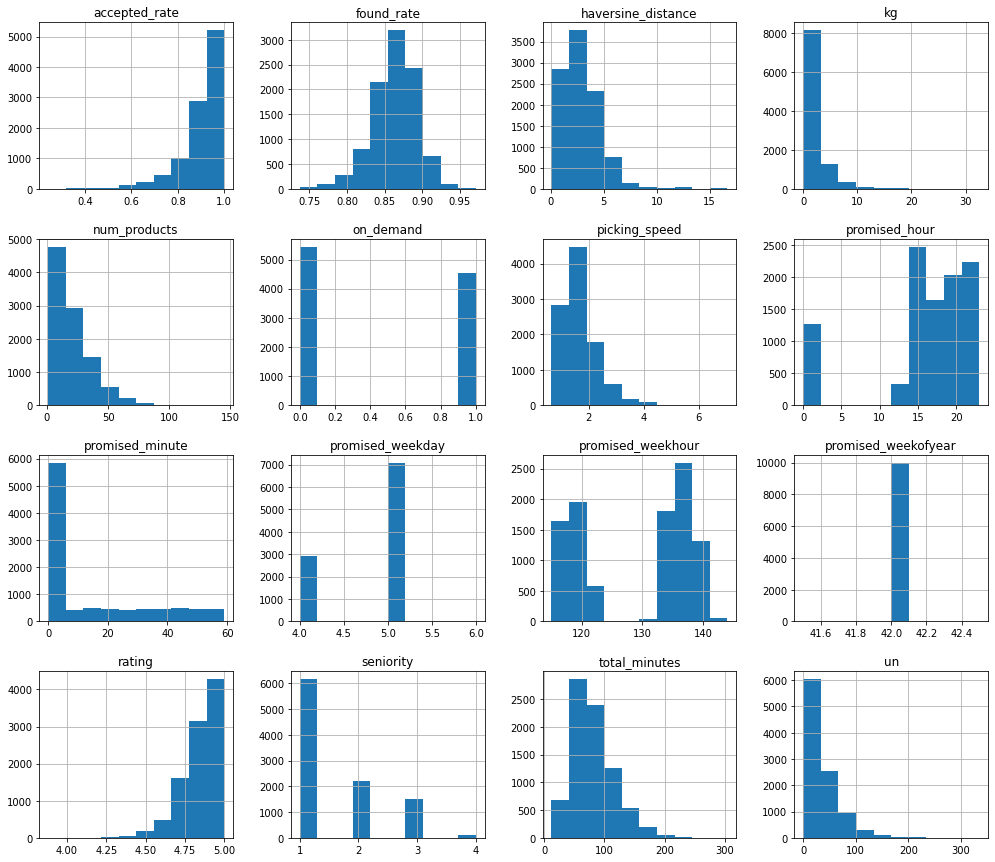

In [44]:
df.hist(figsize=(17, 15))
plt.show()

Most of the distributions are heavy-tailed. We can see that we only have orders from two days (4-Friday and 5-Saturday), so we probably don't have enough data to learn certain patterns, such as which days are the busiest. We can also see that all of the orders are from the same week (42), so we can drop the column `promised_weekofyear`, as it's not informative. 

In [45]:
df = df.drop('promised_weekofyear', axis=1)

### Correlation heatmap

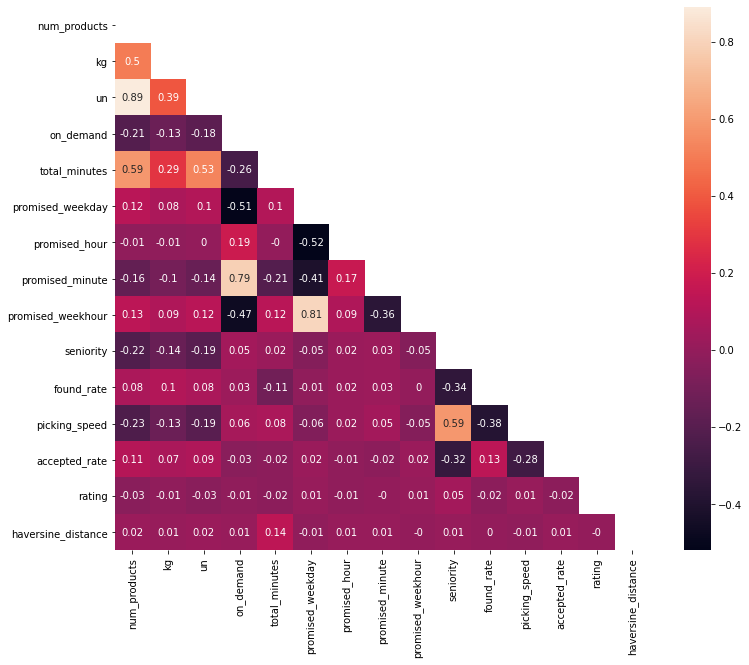

In [46]:
fig, ax = plt.subplots(figsize=(12,10))
corr = df.corr()
mask = np.triu(corr) # get the upper triangle of the correlation matrix
g = sns.heatmap(corr.round(2), annot=True, ax=ax, mask=mask)

As expected, `total_minutes` is highly correlated with `num_products`. It's also highly correlated with `un` and moderately correlated with `kg`.

## Scatter plots for numerical features

In [47]:
def scatterplot(x, y='total_minutes', data=df):
    plt.figure(figsize=(9, 6))
    ax = sns.scatterplot(x=x, y=y, data=data)
    plt.show()

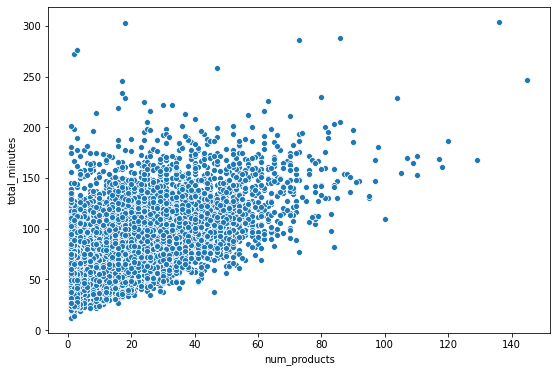

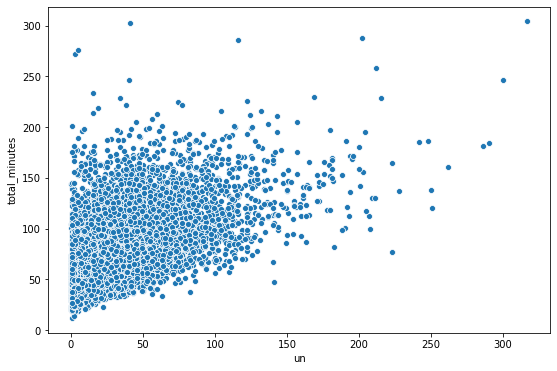

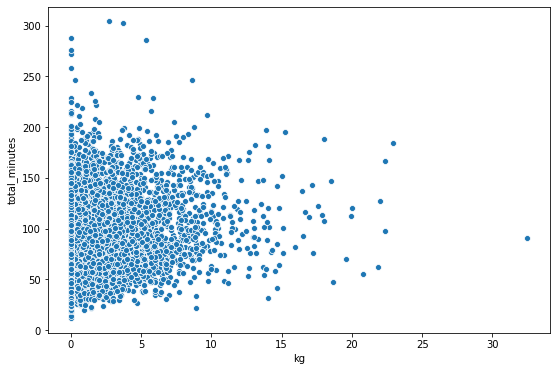

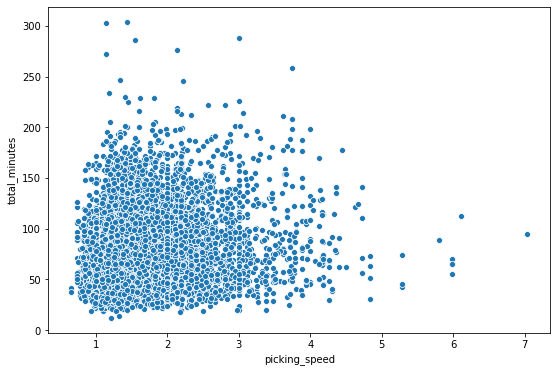

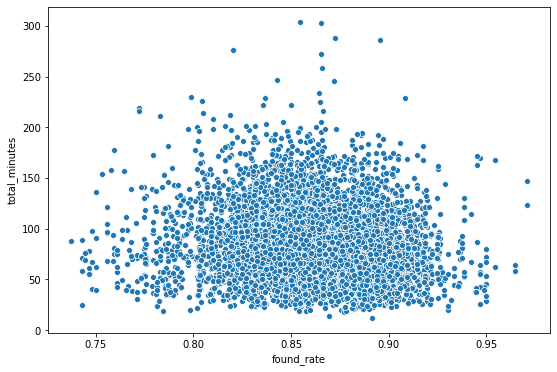

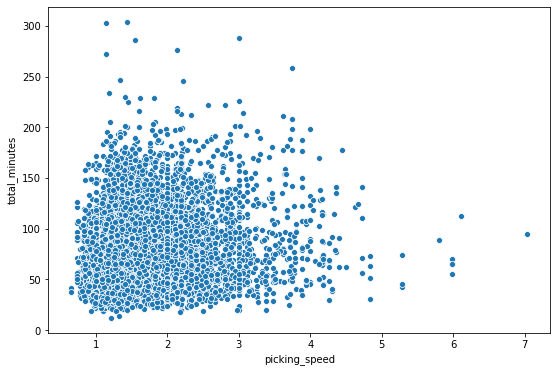

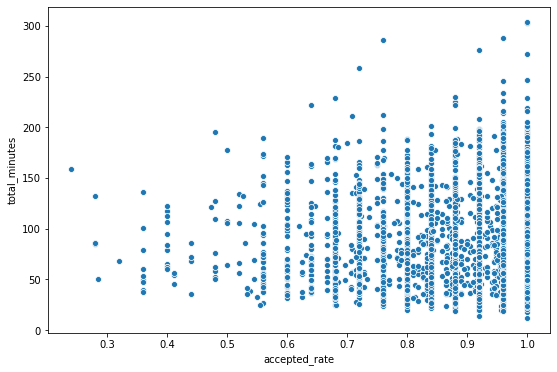

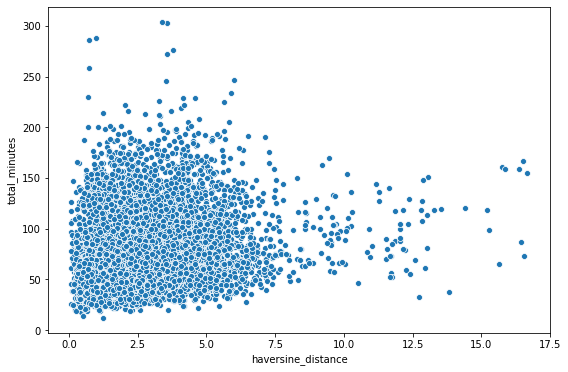

In [48]:
num_feats = [
    'num_products',
    'un',
    'kg',
    'picking_speed',
    'found_rate',
    'picking_speed',
    'accepted_rate',
    'haversine_distance',
]
for f in num_feats:
    scatterplot(f)

## Box plots for categorical features

In [49]:
def boxplot(x, y='total_minutes', data=df):
    plt.figure(figsize=(9, 6))
    ax = sns.boxplot(x=x, y=y, data=data)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    plt.show()

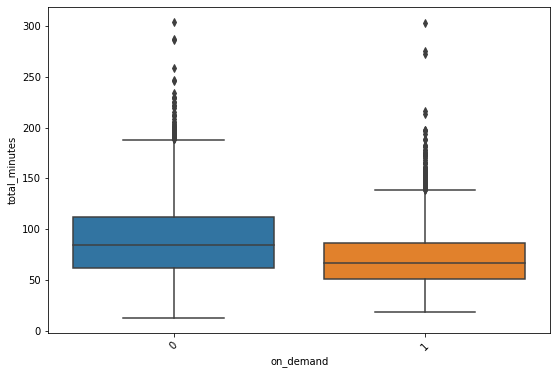

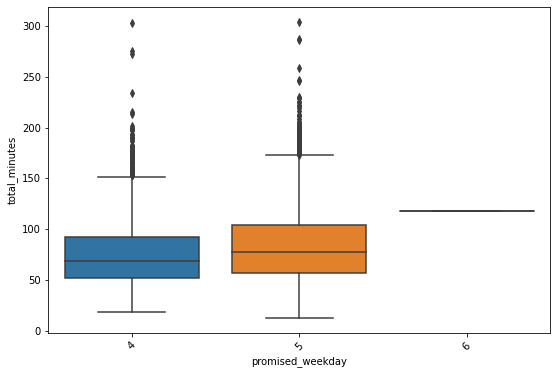

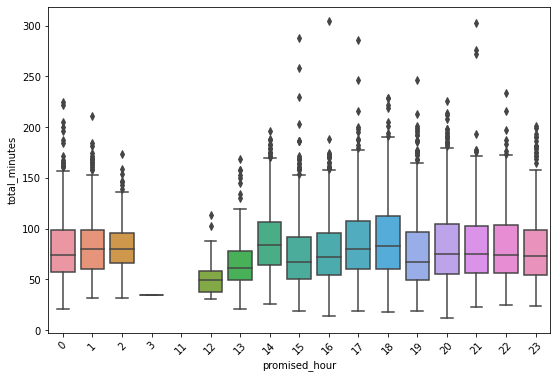

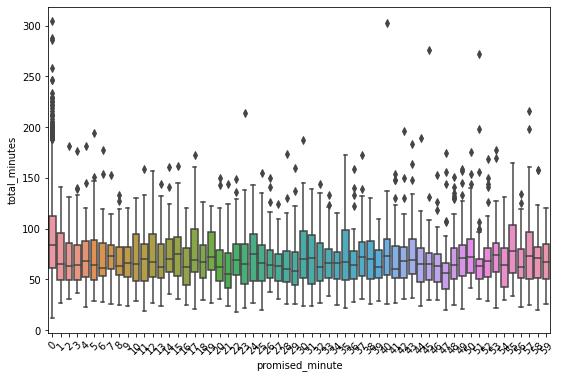

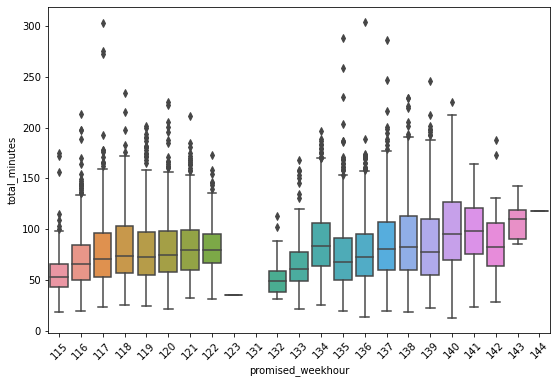

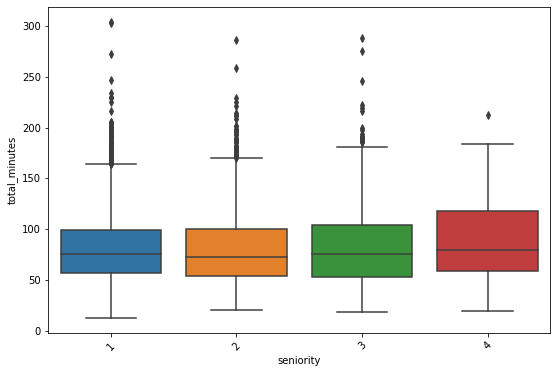

In [50]:
cat_feats = [
    'on_demand',
    'promised_weekday',
    'promised_hour',
    'promised_minute',
    'promised_weekhour',
    'seniority',
]
for f in cat_feats:
    boxplot(f)

## Modeling

### Submission data

Rows not containing a `total_minutes` value should be set aside as a part of the submission file, containing the `order_id` with the predicted values. 

In [51]:
indices = df[df['total_minutes'].isna()].index

In [52]:
submission_df = df.loc[indices]
submission_df.head()

,order_id,num_products,kg,un,on_demand,total_minutes,promised_weekday,promised_hour,promised_minute,promised_weekhour,seniority,found_rate,picking_speed,accepted_rate,rating,haversine_distance
1,0b82d66d7baa5e708fad9a937e8a8654,43,1.72,65.0,0,NaN,5,19,0,139,3,0.8473,2.30,0.92,4.88,2.678250
2,3f889b87769867e6c7f1f17358531d32,12,0.00,16.0,0,NaN,5,0,0,120,3,0.8473,2.30,0.92,4.88,3.999283
5,bd376a4c08c7bf72aba8b2886c034687,6,0.00,10.0,1,NaN,4,21,27,117,3,0.8473,2.30,0.92,4.88,1.537874
10,7e41499170818e6e2f0c007145a5bc39,18,0.00,29.0,0,NaN,5,17,0,137,1,0.8781,1.27,0.92,4.88,1.913916
11,7e75b4de15d6768ac1b5df903208dbbf,3,0.00,7.0,0,NaN,5,19,0,139,1,0.8781,1.27,0.92,4.88,0.864957


In [53]:
df = df.drop(indices)
df.head()

,order_id,num_products,kg,un,on_demand,total_minutes,promised_weekday,promised_hour,promised_minute,promised_weekhour,seniority,found_rate,picking_speed,accepted_rate,rating,haversine_distance
0,0004a3841c1eeb6c6e77585a941c21e0,4,0.000,8.0,1,39.001464,4,20,18,116,3,0.8473,2.3,0.92,4.88,0.481218
3,56b43c66c812ae3ff8e142cf93a46e01,20,2.195,29.0,0,93.703979,5,17,0,137,3,0.8473,2.3,0.92,4.88,1.500918
4,5c5fe557a232694383eb333032efac8b,7,0.000,8.0,0,98.872501,5,0,0,120,3,0.8473,2.3,0.92,4.88,4.258195
6,0007baeb6700fc203be2d1f1e11222d7,22,0.000,39.0,0,136.453089,5,0,0,120,3,0.9012,2.5,1.00,4.92,2.998441
7,fd09fee63f31849ba8789c20ed8bd1ba,7,0.000,11.0,0,137.073484,5,0,0,120,3,0.9012,2.5,1.00,4.92,3.137146


### Train-test split

In [54]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['order_id', 'total_minutes'], axis=1), 
    df['total_minutes'], 
    test_size=0.2, 
    random_state=42)

### Baseline

Let's create a model that always predicts the mean of the training set. Our *real* model has to perform better than this one.

In [55]:
dummy = DummyRegressor(strategy='mean')

In [56]:
dummy.fit(X_train, y_train)

DummyRegressor()

In [57]:
print('MAPE:', mean_absolute_percentage_error(y_test, dummy.predict(X_test)))

MAPE: 0.3979718793855391


### Model

Let's create a XGBoost regressor. XGBoost supports missing values by default, so we don't have to worry with `found_rate`, `picking_speed`, `accepted_rate`, and `rating` missing values for now.

In [58]:
reg = XGBRegressor()

In [59]:
%%time
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)
scores = cross_val_score(reg, X_train, y_train, cv=KFold(n_splits=3), scoring=mape_scorer, n_jobs=-1)

CPU times: user 48 ms, sys: 89.2 ms, total: 137 ms
Wall time: 3.69 s


In [60]:
print('MAPE:', -scores.mean())

MAPE: 0.26696138919714435


### Grid search

Our model already performs better than the baseline, but perhaps we can improve it even more by using more appropriate parameters. We're going to perform a randomized search on hyper parameters.

In [61]:
param_distributions = { 
    'max_depth': [3, 5, 6, 10, 15, 20],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'subsample': np.arange(0.5, 1.0, 0.1),
    'colsample_bytree': np.arange(0.4, 1.0, 0.1),
    'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
    'n_estimators': [100, 500, 1000]
}

In [62]:
n_iter = 100
search = RandomizedSearchCV(
    reg,
    param_distributions=param_distributions,
    n_iter=n_iter,
    cv=3,
    scoring=mape_scorer,
)

In [63]:
%%time
search.fit(X_train, y_train)

CPU times: user 40min 10s, sys: 1min 31s, total: 41min 42s
Wall time: 14min 14s


RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          enable_categorical=False, gamma=None,
                                          gpu_id=None, importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=...
                                          verbosity=None),
                   n_iter=100,
                   param_distributions={'colsample_bylevel': array([0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
 

In [64]:
print('Best score reached: {} with params: {} '.format(-search.best_score_, search.best_params_))

Best score reached: 0.24955328364186236 with params: {'subsample': 0.6, 'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.01, 'colsample_bytree': 0.7999999999999999, 'colsample_bylevel': 0.5} 


### Feature importances

In [65]:
importances = pd.Series(search.best_estimator_.feature_importances_, index=X_train.columns).nlargest(n=10)

In [66]:
for i, v in importances.iteritems():    
    print('Feature: {}, Score: {:.3f}'.format(i, v))

Feature: num_products, Score: 0.162
Feature: on_demand, Score: 0.134
Feature: un, Score: 0.110
Feature: picking_speed, Score: 0.084
Feature: haversine_distance, Score: 0.067
Feature: found_rate, Score: 0.059
Feature: promised_minute, Score: 0.059
Feature: promised_weekhour, Score: 0.055
Feature: kg, Score: 0.053
Feature: rating, Score: 0.051


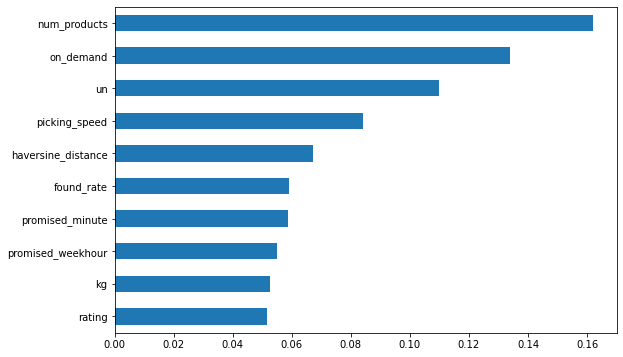

In [67]:
plt.figure(figsize=(9, 6))
importances.plot(kind='barh').invert_yaxis()

## Model evaluation

In [68]:
print('MAPE:', mean_absolute_percentage_error(y_test, search.predict(X_test)))

MAPE: 0.2483844831462065


## Submission file

In [69]:
predicted = search.predict(submission_df.drop(['order_id', 'total_minutes'], axis=1))
predicted

array([137.14212 ,  93.30023 ,  66.642204, ...,  63.0193  ,  84.10213 ,
        61.893402], dtype=float32)

In [70]:
pd.DataFrame({
    'order_id': submission_df['order_id'], 'total_minutes': predicted}
).to_csv('./data/submission.csv', index=False)